[*********************100%%**********************]  1 of 1 completed


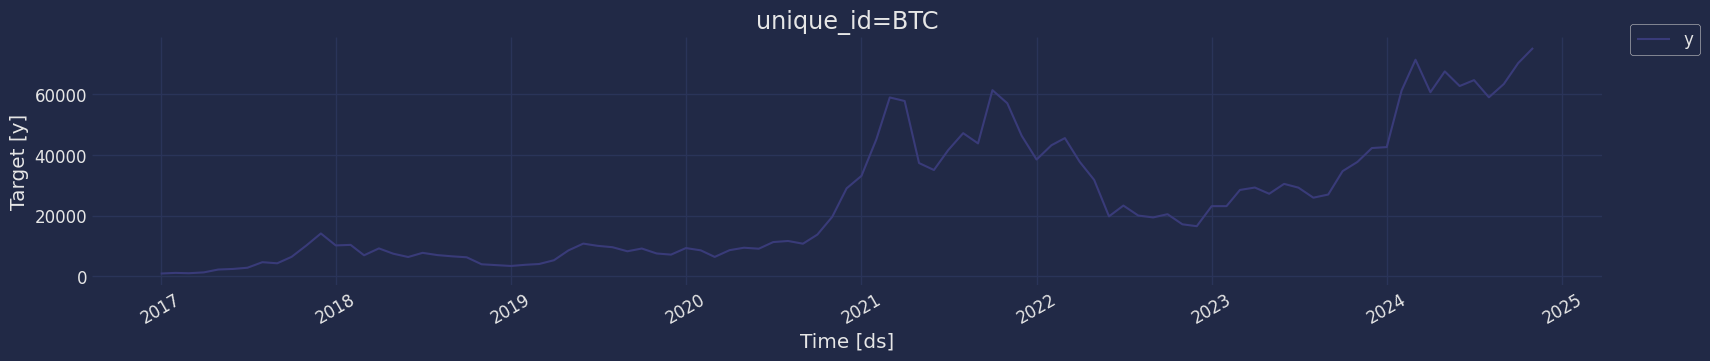

In [67]:
import pandas as pd
import yfinance as yf
from statsforecast import StatsForecast

# Descargar datos de BTC-USD desde 2014-01-01 con intervalo mensual
stocks = ['BTC-USD']
df = yf.download(stocks, start='2017-01-01', interval='1mo')

# Seleccionar y renombrar las columnas necesarias
df = df[['Adj Close']].reset_index()  # Reset index para que la fecha sea una columna
df.columns = ["ds", "y"]  # Renombrar las columnas para que coincidan con el formato StatsForecast

# Agregar una columna de identificador único
df["unique_id"] = "BTC"

# Verificar los tipos de datos
df["ds"] = pd.to_datetime(df["ds"])  # Asegurarse de que la columna ds es datetime




# Visualizar la serie temporal usando StatsForecast
StatsForecast.plot(df)


count       95.000000
mean     24517.491512
std      20941.543557
min        970.403015
25%       7531.899902
50%      17168.566406
75%      38099.000000
max      75211.429688
Name: y, dtype: float64

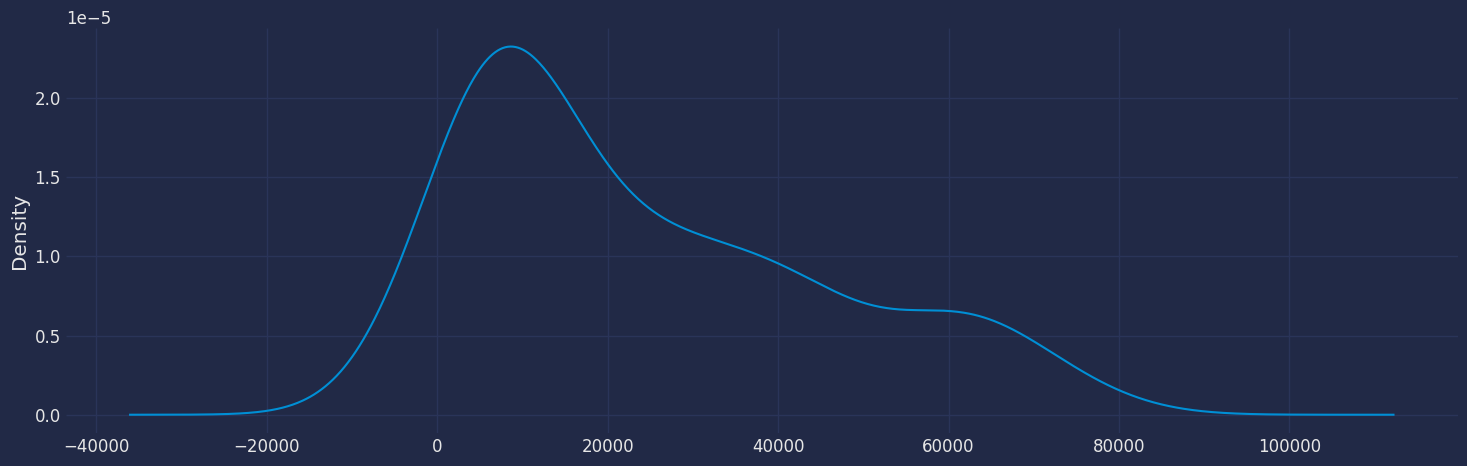

In [68]:
df["y"].plot(kind='kde',figsize = (16,5))
df["y"].describe()


In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose


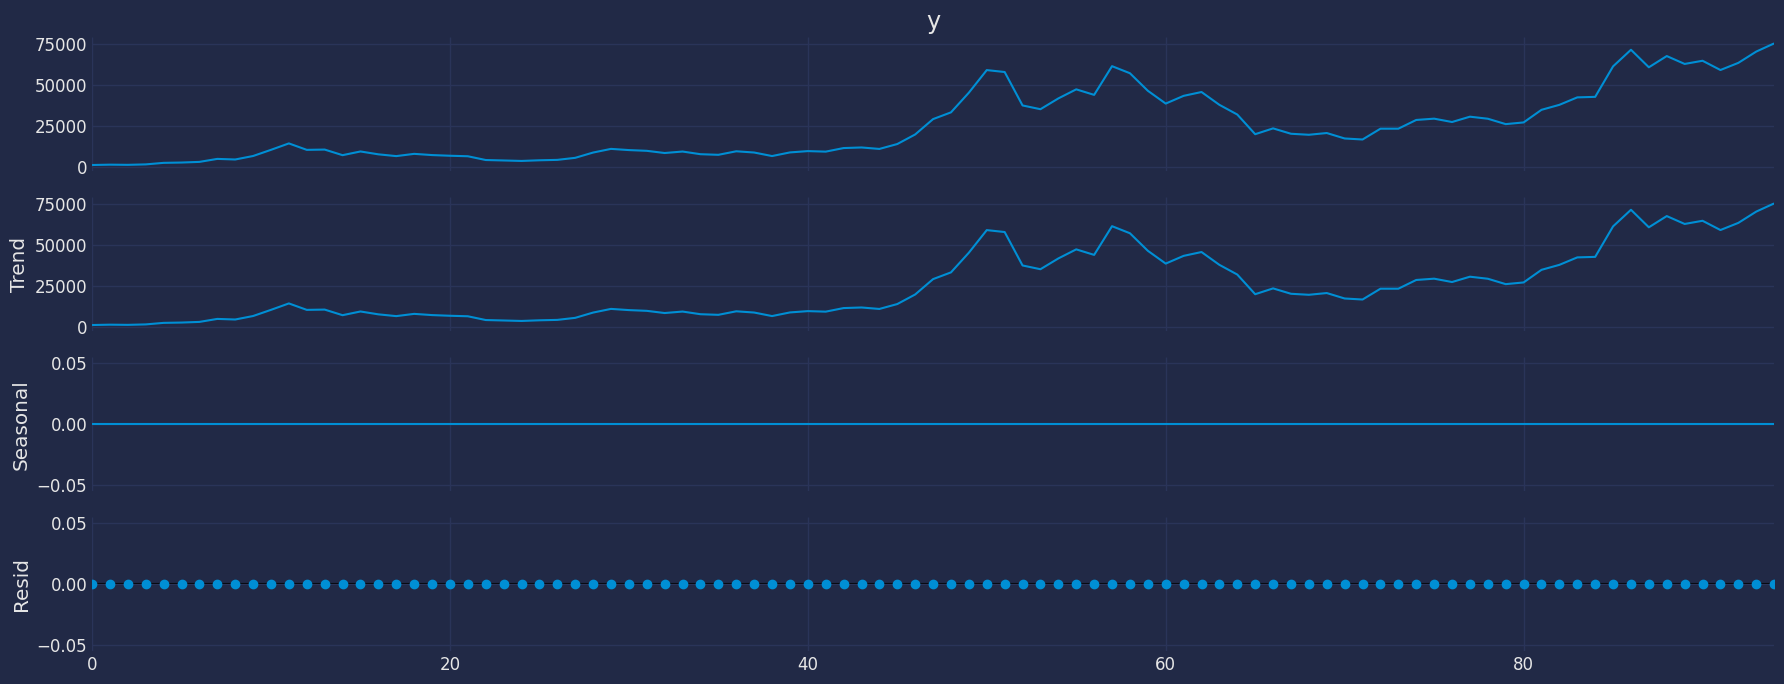

In [70]:
decomposed=seasonal_decompose(df["y"], model = "add", period=1)
decomposed.plot()
plt.show()


In [71]:
from statsmodels.tsa.stattools import adfuller


In [72]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")


In [73]:
Augmented_Dickey_Fuller_Test_func(df["y"],"Life expectancy")


Dickey-Fuller test results for columns: Life expectancy
Test Statistic                 -0.359367
p-value                         0.916665
No Lags Used                    0.000000
Number of observations used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary


In [74]:
df1=df.copy()
df1['y_diff'] = df['y'].diff()
df1.dropna(inplace=True)
df1.head()


,ds,y,unique_id,y_diff
1,2017-02-01,1179.969971,BTC,209.566956
2,2017-03-01,1071.790039,BTC,-108.179932
3,2017-04-01,1347.890015,BTC,276.099976
4,2017-05-01,2286.409912,BTC,938.519897
5,2017-06-01,2480.840088,BTC,194.430176


In [75]:
Augmented_Dickey_Fuller_Test_func(df1["y_diff"],"Life expectancy")


Dickey-Fuller test results for columns: Life expectancy
Test Statistic                -8.314246e+00
p-value                        3.717648e-13
No Lags Used                   0.000000e+00
Number of observations used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


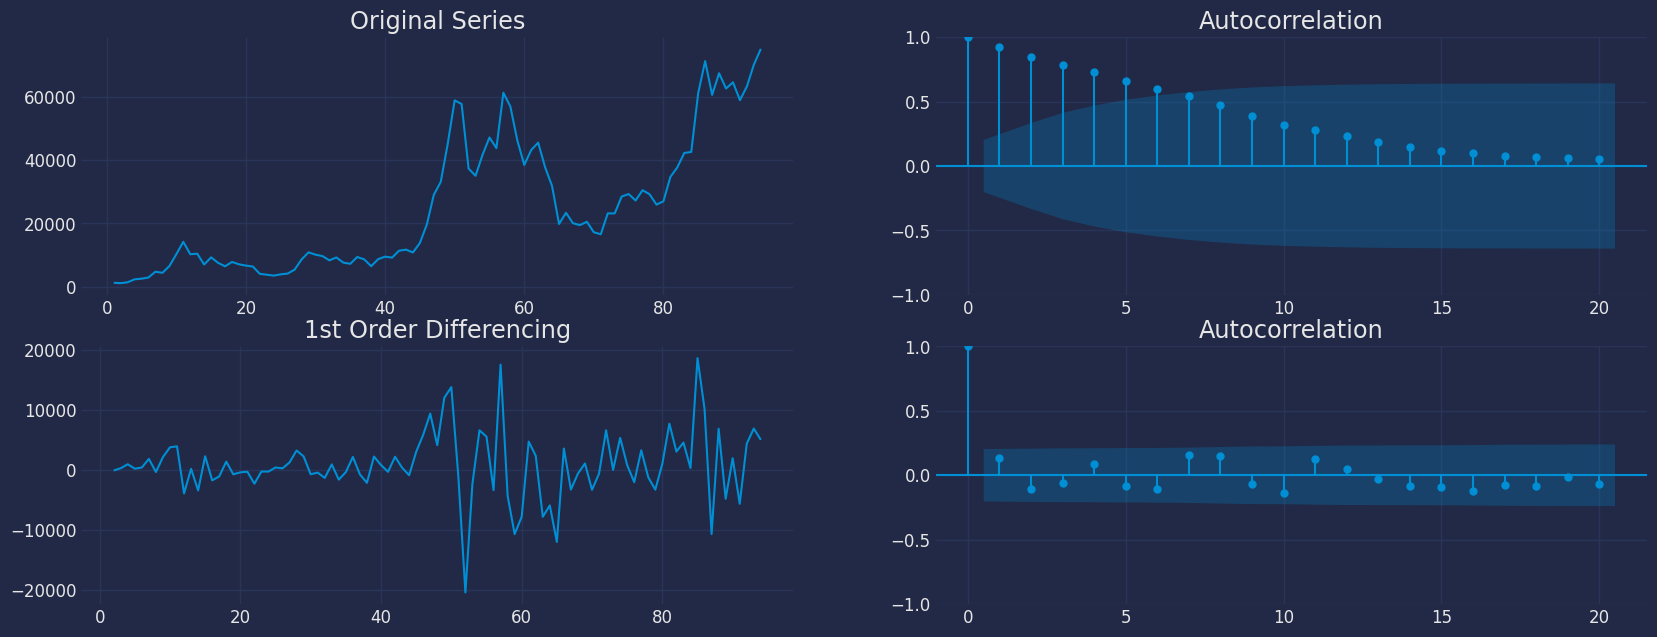

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, )
axes[0, 0].plot(df1["y"]); axes[0, 0].set_title('Original Series')
plot_acf(df1["y"], ax=axes[0, 1],lags=20)

axes[1, 0].plot(df1["y"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1["y"].diff().dropna(), ax=axes[1, 1],lags=20)


plt.show()


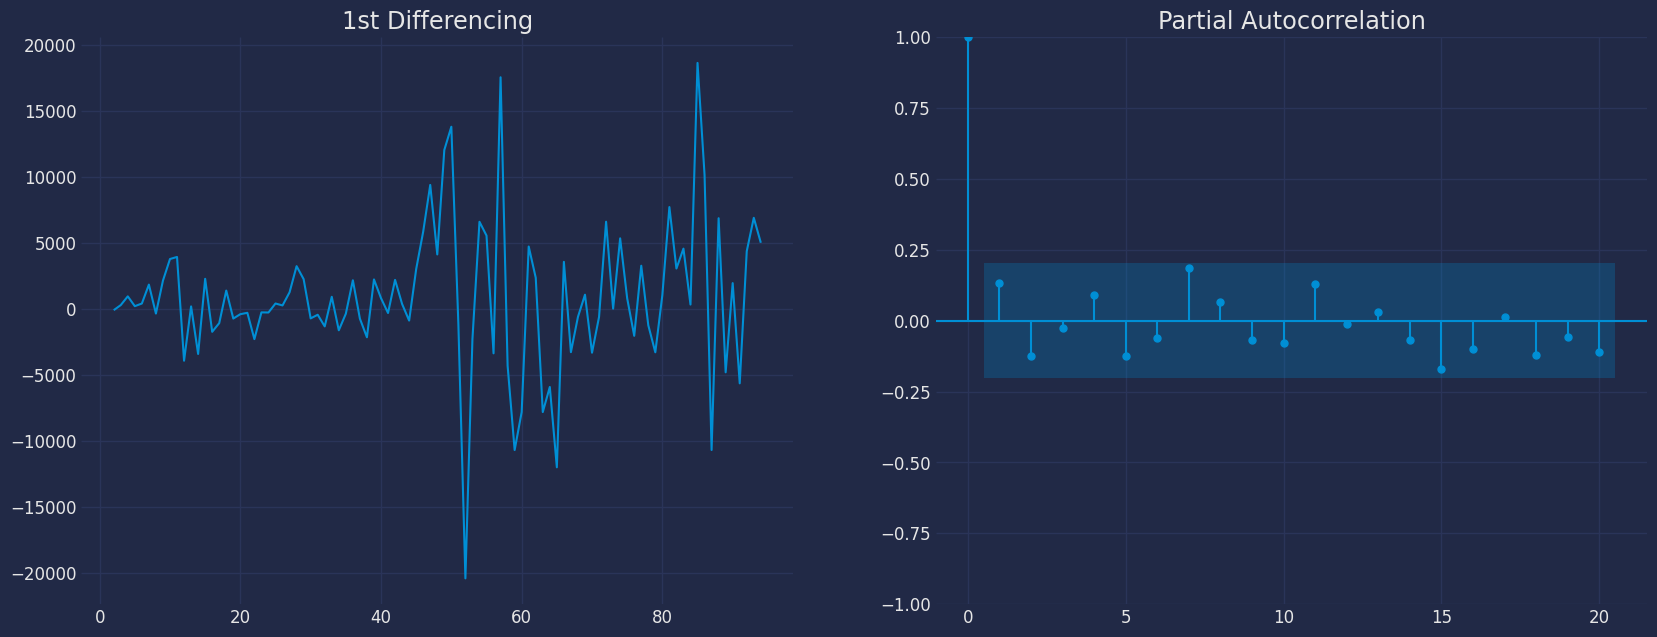

In [77]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df1["y"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df1["y"].diff().dropna(), ax=axes[1],lags=20)

plt.show()


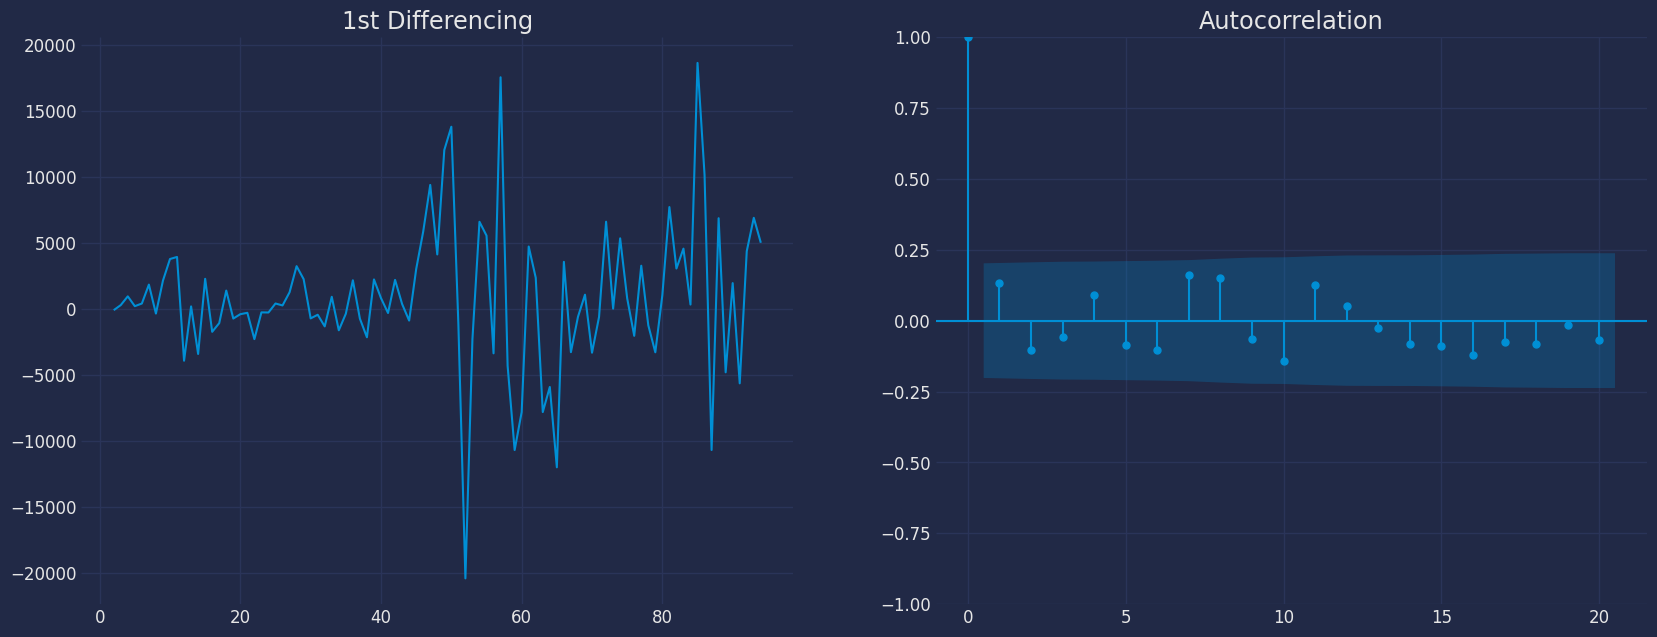

In [78]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 2)
axes[0].plot(df1["y"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df["y"].diff().dropna(), ax=axes[1], lags=20)

plt.show()


In [79]:
from statsforecast.models import ARIMA


In [80]:
arima = ARIMA(order=(1, 1, 1), season_length=1)


In [81]:
arima = arima.fit(y=df["y"].values)


In [82]:
y_hat_dict = arima.predict(h=6,)
y_hat_dict


{'mean': array([75798.07345234, 75712.75673432, 75725.16450682, 75723.36002088,
        75723.6224507 , 75723.58428503])}

In [83]:
y_hat_dict2 = arima.predict(h=6,level=[95])
y_hat_dict2


{'mean': array([75798.07345234, 75712.75673432, 75725.16450682, 75723.36002088,
        75723.6224507 , 75723.58428503]),
 'lo-95': 0    64996.165912
 1    59100.116508
 2    55020.839497
 3    51592.242319
 4    48597.732607
 5    45901.828353
 Name: 95%, dtype: float64,
 'hi-95': 0     86599.980993
 1     92325.396960
 2     96429.489516
 3     99854.477723
 4    102849.512294
 5    105545.340217
 Name: 95%, dtype: float64}

In [84]:
Y_hat_df=arima.forecast(y=df["y"].values, h=6, fitted=True)
Y_hat_df


{'mean': array([75798.07345234, 75712.75673432, 75725.16450682, 75723.36002088,
        75723.6224507 , 75723.58428503]),
 'fitted': array([  969.43261262,   973.37577643,  1213.22000539,  1043.23528064,
         1403.35693262,  2427.07895595,  2469.43774973,  2945.36758622,
         4989.32305194,  4187.53846564,  6874.5679595 , 10740.31715342,
        14658.10446591,  9400.77724084, 10685.15449437,  6306.57659797,
         9831.73757387,  7014.4580008 ,  6370.94131662,  8022.6603392 ,
         6836.42891871,  6619.29560268,  6267.70568347,  3645.46791357,
         3813.14972995,  3387.69165788,  3943.65649569,  4119.72402113,
         5555.99117079,  9053.08073914, 11044.6911879 ,  9890.99460495,
         9615.12049685,  8073.5800802 ,  9421.28347147,  7225.49970125,
         7238.27336946,  9699.81562252,  8363.37833721,  6148.78782735,
         9123.44714467,  9450.31473085,  9086.94895935, 11707.60402101,
        11620.44312125, 10652.46622044, 14327.15776146, 20438.90327032,
    

In [85]:
forecast=pd.Series(pd.date_range("2014-01-01", freq="ys", periods=6))
forecast=pd.DataFrame(forecast)
forecast.columns=["ds"]
forecast


C:\Users\ferna\AppData\Local\Temp\ipykernel_12844\2814400862.py:1: FutureWarning: 'ys' is deprecated and will be removed in a future version, please use 'YS' instead.
  forecast=pd.Series(pd.date_range("2014-01-01", freq="ys", periods=6))


,ds
0,2014-01-01
1,2015-01-01
2,2016-01-01
3,2017-01-01
4,2018-01-01
5,2019-01-01


In [86]:
df=df.set_index("ds")


In [87]:
forecast["unique_id"]="1"
forecast["hat"]=y_hat_dict.get("mean")
forecast["lo-95"]=y_hat_dict2.get("lo-95")
forecast["hi-95"]=y_hat_dict2.get("hi-95")
forecast=forecast.set_index("ds")
forecast


,unique_id,hat,lo-95,hi-95
ds,,,,
2014-01-01,1,75798.073452,64996.165912,86599.980993
2015-01-01,1,75712.756734,59100.116508,92325.396960
2016-01-01,1,75725.164507,55020.839497,96429.489516
2017-01-01,1,75723.360021,51592.242319,99854.477723
2018-01-01,1,75723.622451,48597.732607,102849.512294
2019-01-01,1,75723.584285,45901.828353,105545.340217


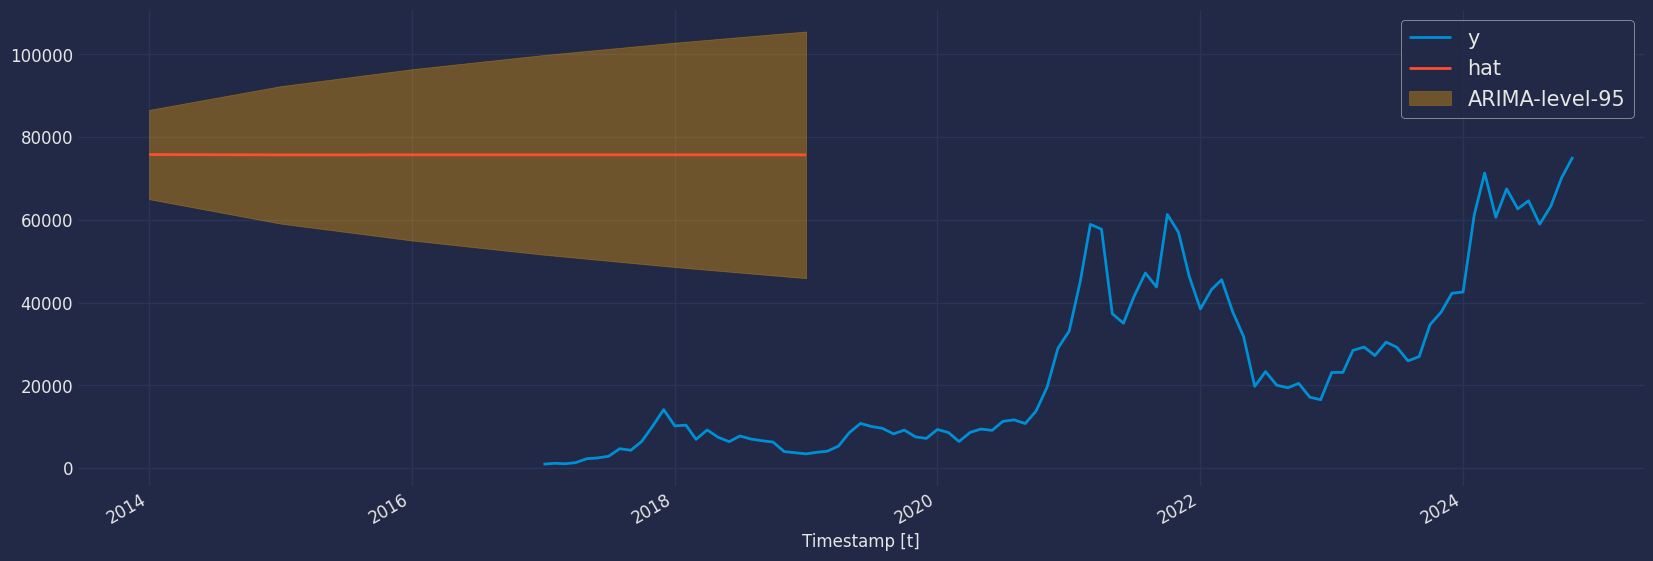

In [88]:
_, ax = plt.subplots(1, 1)
df_plot = pd.concat([df, forecast])
df_plot[['y', 'hat']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index, 
                df_plot['lo-95'], 
                df_plot['hi-95'],
                alpha=.35,
                color='orange',
                label='ARIMA-level-95')
ax.set_title('', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=12)
ax.legend(prop={'size': 15})
ax.grid(True)


In [89]:
df.reset_index("ds", inplace=True)
Y_train_df = df[df.ds<='2013-01-01'] 
Y_test_df = df[df.ds>'2013-01-01'] 

Y_train_df.shape, Y_test_df.shape


((0, 3), (95, 3))

In [90]:
from sklearn import metrics

def model_evaluation(y_true, y_pred, Model):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print (f'Model Evaluation: {Model}')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}')
    print(f'corr is : {np.corrcoef(y_true, y_pred)[0,1]}',end='\n\n')


In [91]:
model_evaluation(Y_test_df["y"], forecast["hat"], "Arima")


Model Evaluation: Arima


ValueError: Found input variables with inconsistent numbers of samples: [95, 6]